In [29]:
from market_data_loader.data_handler import *
from european_option import *

In [30]:
tickers = {
    "LVMH": "MC.PA",
    "Danone": "BN.PA",
    "Siemens": "SIE.DE",
    "AXA": "CS.PA",
    "Engie": "ENGI.PA",
    "Société Générale": "GLE.PA",
    "BNP Paribas": "BNP.PA",
    "L'Oréal": "OR.PA"
}
tickers.values()

dict_values(['MC.PA', 'BN.PA', 'SIE.DE', 'CS.PA', 'ENGI.PA', 'GLE.PA', 'BNP.PA', 'OR.PA'])

In [31]:
tickers = ['MC.PA', 'BN.PA', 'SIE.DE', 'CS.PA', 'ENGI.PA', 'GLE.PA', 'BNP.PA', 'OR.PA']
handler_future = OnlineDataHandler(tickers, macro_region="europe", start ="2017-04-06", end ="2019-04-06")
handler = OnlineDataHandler(tickers, macro_region="europe", start ="2017-04-06", end ="2018-04-06")

handler_future.load_data()
handler.load_data()

print("\nDernier bar pour Hermes :")
print(handler.get_latest_bar('MC.PA'))
print(handler_future.get_latest_bar('MC.PA'))

print("\nVariables macroéconomiques :")
print(handler.macro_data.tail())
print(handler_future.macro_data.tail())

- Loading market data (1Day)...
MC.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
BN.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
SIE.DE: 507 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
CS.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
ENGI.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
GLE.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
BNP.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]
OR.PA: 510 obs from Yahoo Finance (2017-04-06 → 2019-04-05) [1Day]

 Market data successfully loaded
Tickers: 8 | Period: 2017-04-06 → 2019-04-05
Observations: 510 | Timeframe: 1Day
- Loading macroeconomic data (EUROPE)...
[WARN] M1SUPPLY: Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=MABMM201EZM189S Response Text [WARN] This message is too long, cannot print it entirely
[WARN] CCREDIT: Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=QEZLOCOO

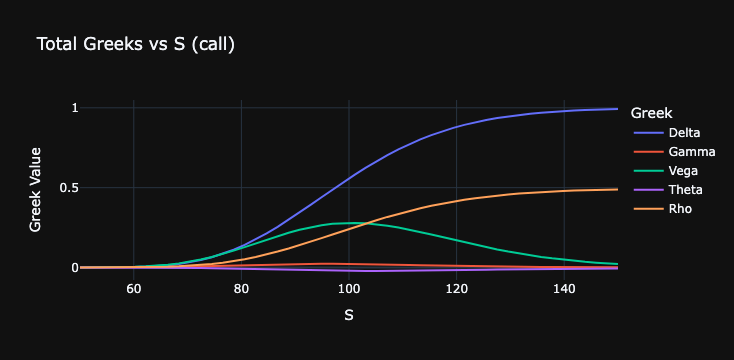

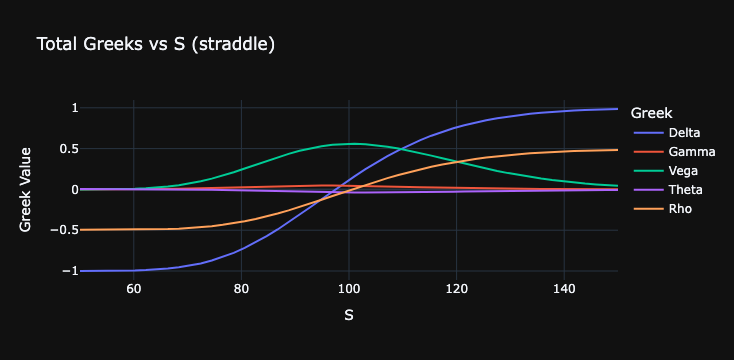

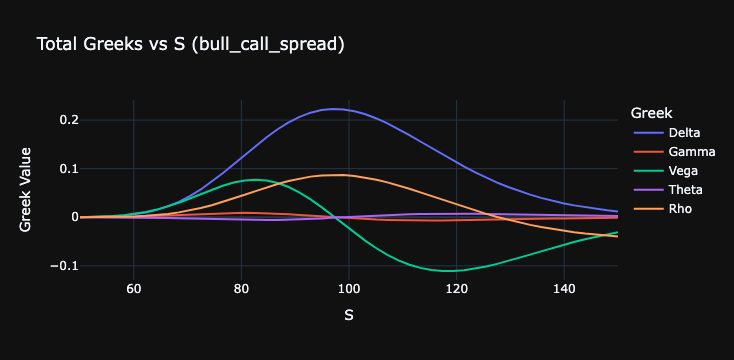

In [32]:
# Exemple 1 : Call simple
call = EuropeanOption(S=100, K=100, T=0.5, r=0.02, sigma=0.25, option_type="call")
call.plot_greeks(x_axis="S")

# Exemple 2 : Straddle
straddle = EuropeanOption(S=100, K=[100], T=0.5, r=0.02, sigma=0.25, derivatives="straddle")
straddle.plot_greeks(x_axis="S")

# Exemple 3 : Bull Call Spread
spread = EuropeanOption(S=100, K=[95, 105], T=0.5, r=0.02, sigma=0.25, derivatives="bull_call_spread")
spread.plot_greeks(x_axis="S")


In [44]:
from abc import ABC, abstractmethod
from typing import Dict, List
import pandas as pd
from dataclasses import dataclass
from enum import Enum # Enum is a module that provides support for enumerations

class SignalType(Enum):
    """ Enumeration for signal types """
    BUY = "BUY"
    SELL = "SELL"
    HOLD = "HOLD"
    EXIT = "EXIT"

@dataclass
class Signal:
    """ Represents a trading signal """
    symbol: str
    signal_type: SignalType
    price: float
    volume: float

    def __post_init__(self):
    #    if self.volume <= 0:
     #       raise ValueError("Volume must be positive")

        if self.signal_type not in SignalType:
            raise ValueError(f"Invalid signal type: {self.signal_type}")

class Strategy(ABC):
    """ Abstract base class for trading strategies """
    @abstractmethod
    def generate_signals(self, data: Dict[str, pd.DataFrame]) -> List[Signal]:
        """ Generates trading signals based on the provided data """
        pass

class MovingAverageCrossoverStrategy(Strategy):
    """ Simple moving average crossover strategy """
    def __init__(self, short_window: int = 40, long_window: int = 100):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data: Dict[str, pd.DataFrame]) -> List[Signal]:
        signals = []
        for symbol, df in data.items():
            df['short_mavg'] = df['close'].rolling(window=self.short_window, min_periods=1).mean()
            df['long_mavg'] = df['close'].rolling(window=self.long_window, min_periods=1).mean()

            if df['short_mavg'].iloc[-1] > df['long_mavg'].iloc[-1]:
                signals.append(Signal(symbol=symbol, signal_type=SignalType.BUY, price=df['close'].iloc[-1], volume=100))
            elif df['short_mavg'].iloc[-1] < df['long_mavg'].iloc[-1]:
                signals.append(Signal(symbol=symbol, signal_type=SignalType.SELL, price=df['close'].iloc[-1], volume=100))
            else:
                signals.append(Signal(symbol=symbol, signal_type=SignalType.HOLD, price=df['close'].iloc[-1], volume=0))
        return signals

In [19]:
strategy = MovingAverageCrossoverStrategy(short_window=2, long_window=3)

Portfolio

In [22]:
from dataclasses import dataclass, field
from typing import Dict

@dataclass
class Portfolio:
    cash: float = 0.0
    positions: Dict[str, int] = field(default_factory=dict)

    def qty(self, symbol: str) -> int:
        return self.positions.get(symbol, 0)

    def apply_fill(self, fill: Fill, fee: float) -> None:
        sign = 1 if fill.qty > 0 else -1
        notional = abs(fill.qty) * fill.price
        # BUY reduces cash, SELL increases cash
        self.cash += (-notional - fee) if sign > 0 else (notional - fee)
        self.positions[fill.symbol] = self.qty(fill.symbol) + fill.qty
        if self.positions[fill.symbol] == 0:
            self.positions.pop(fill.symbol)

    def market_value(self, prices: Dict[str, float]) -> float:
        return sum(self.qty(sym) * prices.get(sym, 0.0) for sym in self.positions)

    def equity(self, prices: Dict[str, float]) -> float:
        return self.cash + self.market_value(prices)

In [23]:
portfolio = Portfolio(cash=100_000)

BROKER

In [24]:
from typing import Tuple

class BacktestBroker:
    def __init__(self, fee_model: FeeModel, slippage_bps: float = 0.0):
        self.fee_model = fee_model
        self.slippage_bps = slippage_bps

    def _apply_slippage(self, price: float, side: SignalType) -> float:
        # BUY pays up, SELL gets less
        adj = price * (self.slippage_bps / 10_000.0)
        return price + adj if side == SignalType.BUY else price - adj

    def order_for_signal(self, sig: Signal) -> OrderRequest:
        if sig.signal_type == SignalType.HOLD or sig.volume == 0:
            return OrderRequest(symbol=sig.symbol, qty=0, side="HOLD")
        side = "BUY" if sig.signal_type == SignalType.BUY else "SELL"
        qty = int(sig.volume) if side == "BUY" else -int(sig.volume)
        return OrderRequest(symbol=sig.symbol, qty=qty, side=side)

    def execute(self, req: OrderRequest, mkt_price: float) -> Tuple[Fill, float]:
        if req.qty == 0:
            return Fill(req.symbol, 0, mkt_price), 0.0
        traded_price = self._apply_slippage(mkt_price, SignalType.BUY if req.qty > 0 else SignalType.SELL)
        notional = abs(req.qty) * traded_price
        fee = self.fee_model.fee(notional)
        return Fill(req.symbol, req.qty, traded_price), fee

In [25]:
import math
from typing import List, Dict

class PerformanceMetrics:
    def __init__(self, equity_curve: List[float]):
        self.equity = equity_curve
        self.returns = [0.0] + [
            (self.equity[i] / self.equity[i-1] - 1.0) for i in range(1, len(self.equity))
        ]

    def summary(self, periods_per_year: int = 252) -> Dict[str, float]:
        if not self.equity or len(self.equity) < 2:
            return {"total_return": 0.0, "vol": 0.0, "sharpe": 0.0, "max_dd": 0.0}
        total_return = self.equity[-1] / self.equity[0] - 1.0
        mean = sum(self.returns[1:]) / max(1, len(self.returns) - 1)
        var = sum((r - mean) ** 2 for r in self.returns[1:]) / max(1, len(self.returns) - 2)
        vol = math.sqrt(var) * math.sqrt(periods_per_year)
        sharpe = (mean * periods_per_year) / vol if vol > 0 else 0.0
        # max drawdown
        peak = self.equity[0]
        max_dd = 0.0
        for v in self.equity:
            peak = max(peak, v)
            dd = (v / peak) - 1.0
            max_dd = min(max_dd, dd)
        return {
            "total_return": total_return,
            "vol": vol,
            "sharpe": sharpe,
            "max_dd": max_dd,
        }

In [31]:
from typing import Dict, List

class Backtester:
    def __init__(self, data: Dict[str, pd.DataFrame], strategy: Strategy, broker: BacktestBroker, portfolio: Portfolio):
        self.data = data
        self.strategy = strategy
        self.broker = broker
        self.portfolio = portfolio
        self.equity_curve: List[float] = []

    def _prices_snapshot(self, t: int) -> Dict[str, float]:
        return {sym: df['close'].iloc[t] for sym, df in self.data.items() if t < len(df)}

    def run(self) -> PerformanceMetrics:
        # assume all symbols share the same index length for brevity
        T = min(len(df) for df in self.data.values())
        for t in range(T):
            # 1) Generate signals using history up to t
            hist = {sym: df.iloc[: t + 1] for sym, df in self.data.items()}
            signals = self.strategy.generate_signals(hist)
            prices = self._prices_snapshot(t)

            # 2) Convert to order requests and execute
            for sig in signals:
                req = self.broker.order_for_signal(sig)
                if req.qty == 0:
                    continue
                mkt_px = prices.get(req.symbol)
                if mkt_px is None:
                    continue
                fill, fee = self.broker.execute(req, mkt_px)
                self.portfolio.apply_fill(fill, fee)

            # 3) Record equity
            self.equity_curve.append(self.portfolio.equity(prices))

        return PerformanceMetrics(self.equity_curve)

In [46]:
data

{'AAPL':    close
 0    100
 1    101
 2    102
 3    101
 4    103,
 'MSFT':    close
 0    100
 1    101
 2    102
 3    101
 4    103}

In [56]:
handler.price_close_df['AAPL'].dtype

pandas.core.series.Series

In [ ]:
#Inputs
symbols = ["AAPL", "MSFT"]
data = {s: pd.DataFrame({"close": handler.price_close_df[s] }) for s in handler.price_close_df.columns}

strategy = MovingAverageCrossoverStrategy(short_window=2, long_window=3)
broker = BacktestBroker(FixedBpsFee(1.0), slippage_bps=2.0)
portfolio = Portfolio(cash=100_00000000)

bt = Backtester(data, strategy, broker, portfolio)
metrics = bt.run().summary()

print({k: round(v, 4) for k, v in metrics.items()})

In [36]:
data = handler 
strategy = MovingAverageCrossoverStrategy(short_window=2, long_window=3)
broker = BacktestBroker(FixedBpsFee(1.0), slippage_bps=2.0)
portfolio = Portfolio(cash=100_0000000)

bt = Backtester(data, strategy, broker, portfolio)
metrics = bt.run().summary()

print({k: round(v, 4) for k, v in metrics.items()})

AttributeError: 'OnlineDataHandler' object has no attribute 'values'

/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_4765/915174676.py:18: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  8 of 8 completed


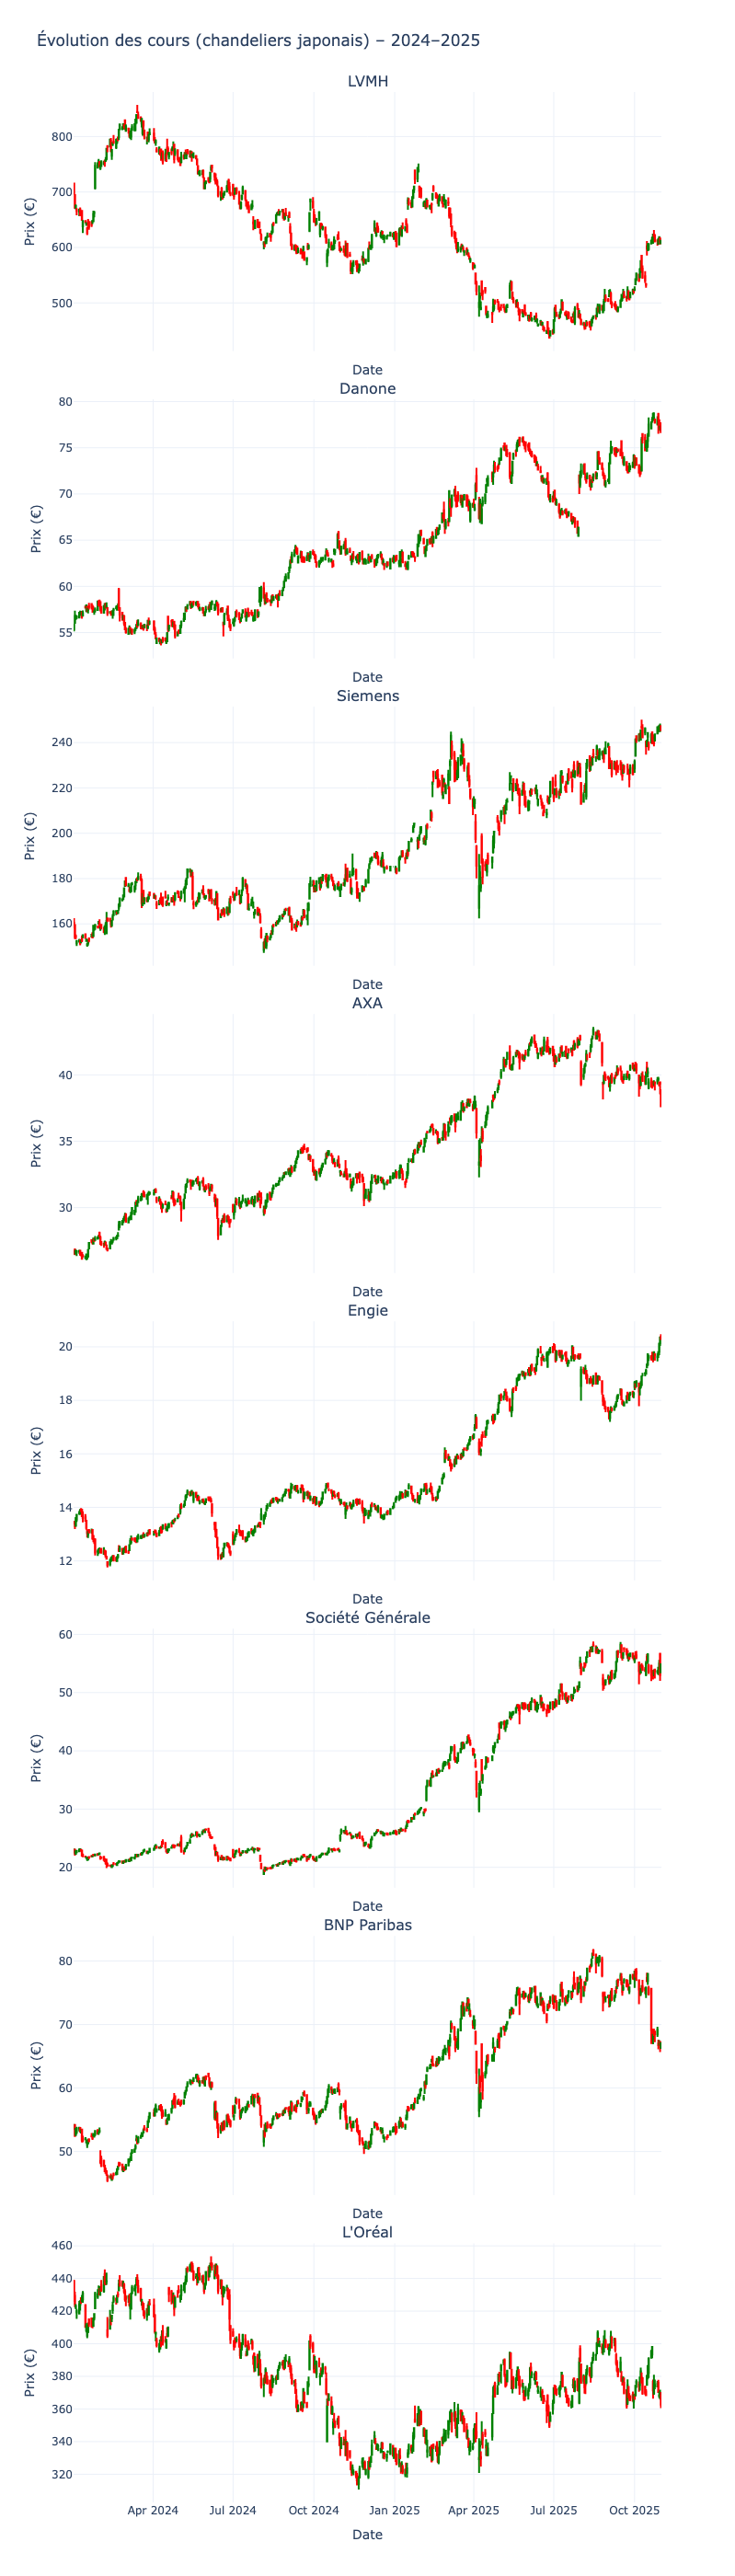

In [10]:
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Dictionnaire des tickers ---


# --- Téléchargement des données OHLC (open-high-low-close) ---
data = yf.download(list(tickers.values()), start="2024-01-01", end="2025-11-01")

# --- Création des sous-graphiques ---
fig = make_subplots(
    rows=len(tickers),
    cols=1,
    shared_xaxes=True,
    subplot_titles=list(tickers.keys()),
    vertical_spacing=0.02
)

# --- Ajout des chandeliers ---
for i, (name, ticker) in enumerate(tickers.items(), start=1):
    df = data.xs(ticker, axis=1, level=1)  # isole les colonnes du ticker
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['Open'],
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            name=name,
            increasing_line_color='green',
            decreasing_line_color='red'
        ),
        row=i, col=1
    )

# --- Mise en forme ---
fig.update_layout(
    height=350 * len(tickers),
    title="Évolution des cours (chandeliers japonais) – 2024–2025",
    template="plotly_white",
    showlegend=False
)

fig.update_xaxes(title_text="Date", rangeslider_visible=False)
fig.update_yaxes(title_text="Prix (€)")

# --- Affichage ---
fig.show()
